<a href="https://colab.research.google.com/github/NSTHEHACKER/Cyber_-security-/blob/main/Copy_of_training_object_detection_on_custom_data_yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [23]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16554, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 16554 (delta 17), reused 27 (delta 13), pack-reused 16522
Receiving objects: 100% (16554/16554), 15.01 MiB | 13.48 MiB/s, done.
Resolving deltas: 100% (11376/11376), done.
/content/yolov5/yolov5


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.
Setup complete. Using torch 2.2.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


## Step 6: Download a Dataset

Add your Roboflow API key below to download the default money counting dataset. Alternatively, use the code provided by the Roboflow dashboard in the above step to load a custom dataset.

In [3]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.6 MB/s eta 0:00:00


In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PwwNrAIvEwrNr0BVjGv3")
project = rf.workspace("peacock-qoibg").project("peacock-tgsej")
version = project.version(1)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to peacock-1 in yolov5pytorch:: 100%|██████████| 676/676 [00:00<00:00, 5704.73it/s]


In [6]:
%pwd

'/content/yolov5'

In [7]:
dataset.location

'/content/yolov5/peacock-1'

In [8]:
%cd /content/yolov5

/content/yolov5


In [9]:
dataset.location

'/content/yolov5/peacock-1'

In [10]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- object
nc: 1
roboflow:
  license: CC BY 4.0
  project: peacock-tgsej
  url: https://universe.roboflow.com/peacock-qoibg/peacock-tgsej/dataset/1
  version: 1
  workspace: peacock-qoibg
test: ../test/images
train: peacock-1/train/images
val: peacock-1/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [11]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [14]:
num_classes

'1'

In [12]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5x.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 1.33 # model depth multiple
width_multiple: 1.25 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [13]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [15]:
%%writetemplate /content/yolov5/models/custom_yolov5x.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [16]:
# train yolov5s on custom data for 200 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 20 --epochs 60 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5x.yaml --weights 'yolov5x.pt' --name yolov5s_results  --cache

/content/yolov5
2024-04-16 06:35:45.450571: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 06:35:45.450623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 06:35:45.452099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5x.pt, cfg=./models/custom_yolov5x.yaml, data=/content/yolov5/peacock-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=60, batch_size=20, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, ima

# Evaluate Custom YOLOv5 Detector Performance

You can view the training graphs associated with a training job in the `/content/yolov5/runs/train/yolov5s_results/results.png` folder.

Training losses and performance metrics are also saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

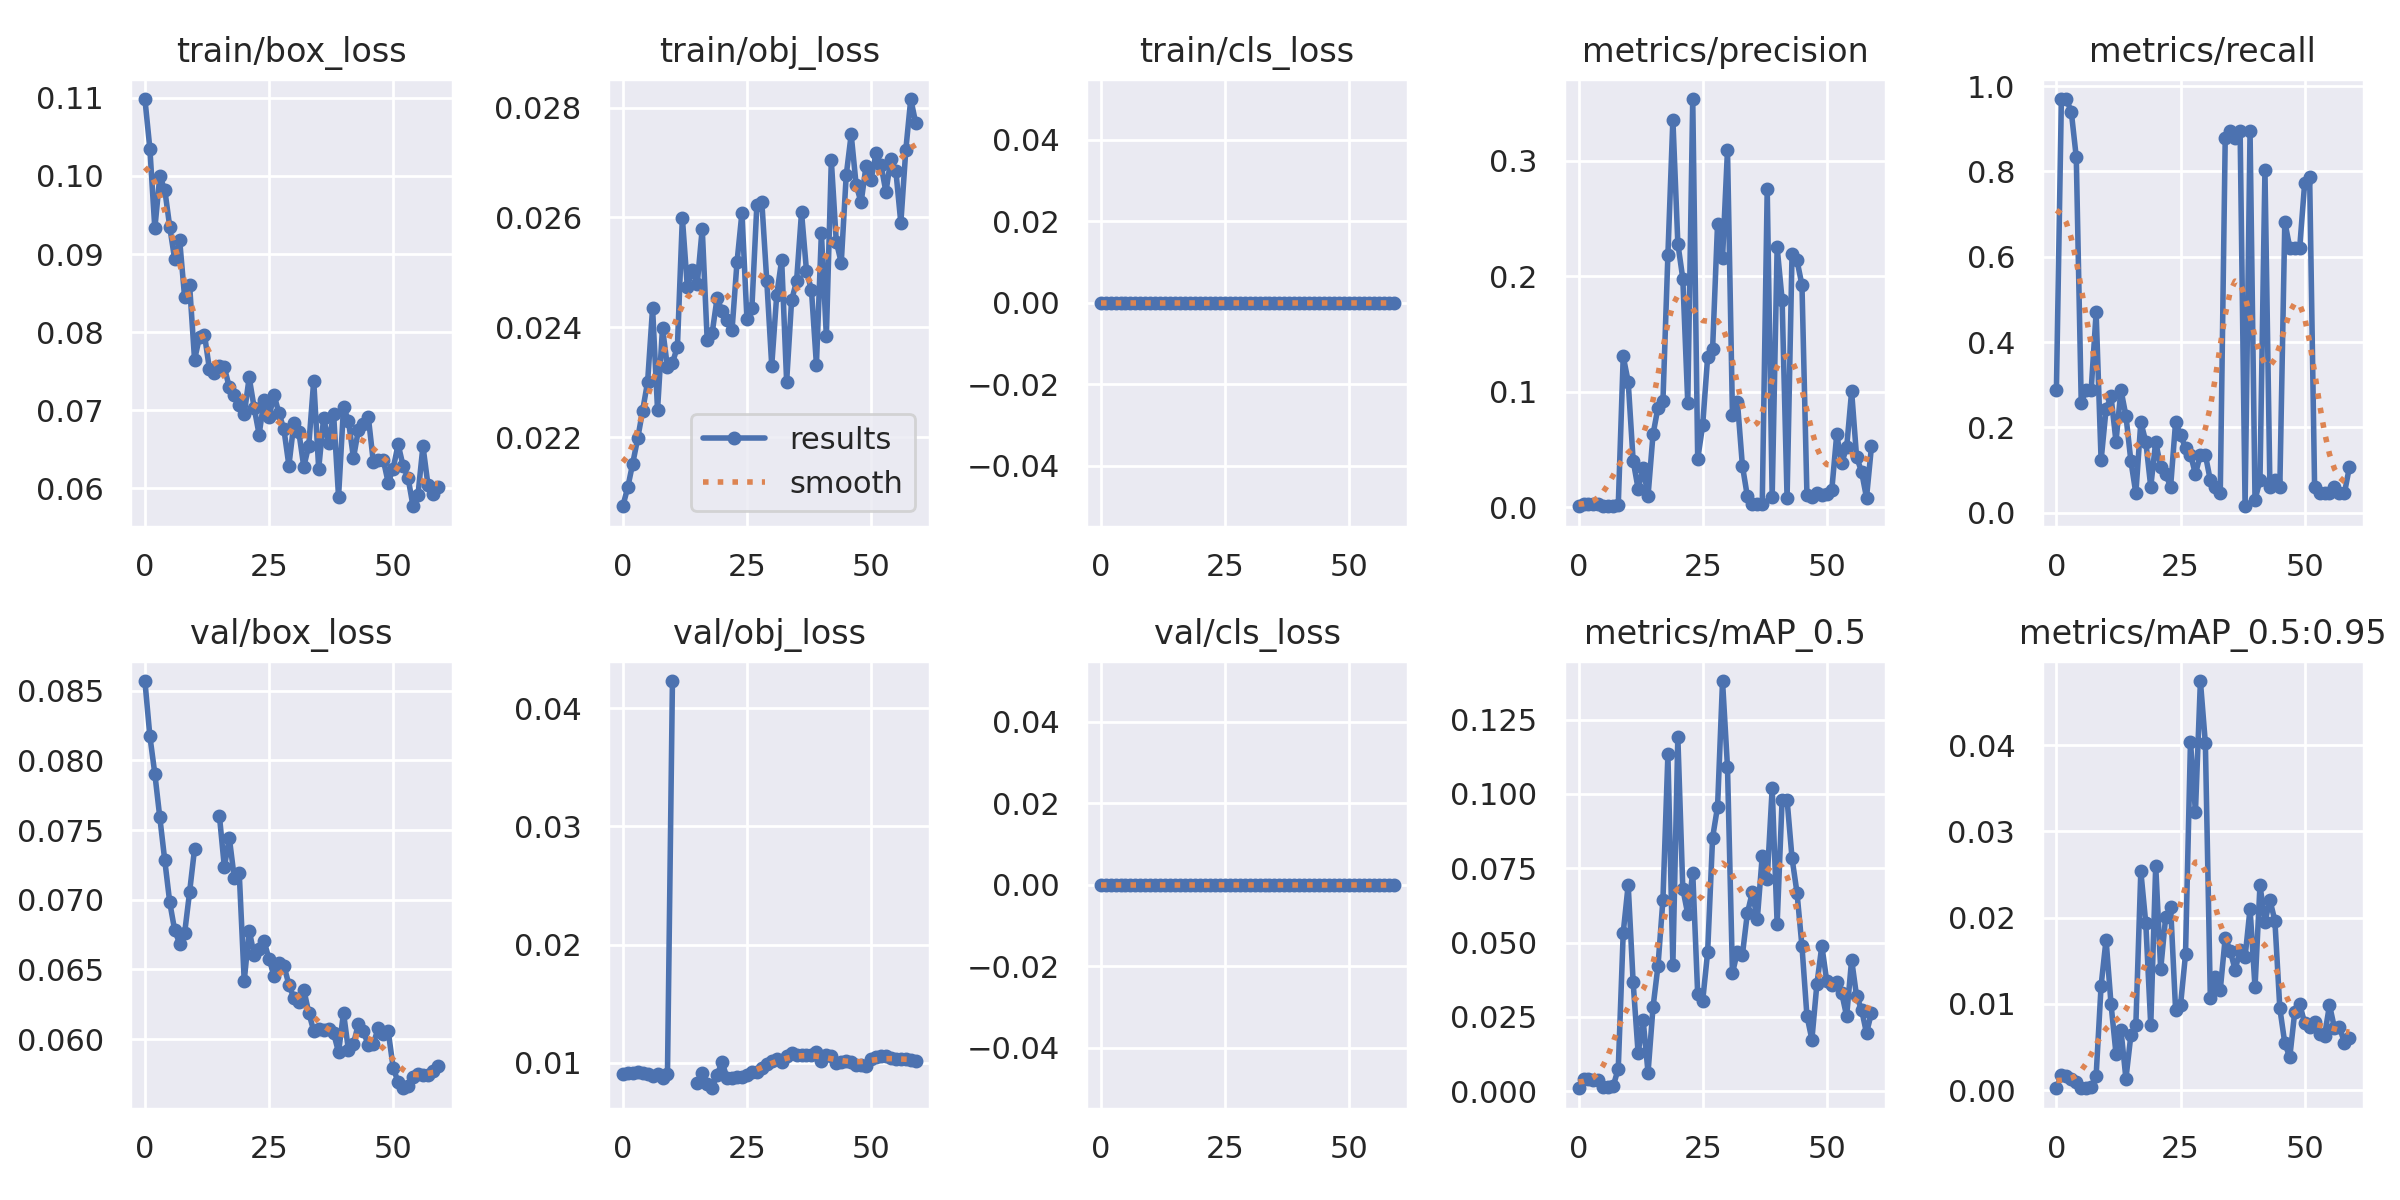

In [17]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

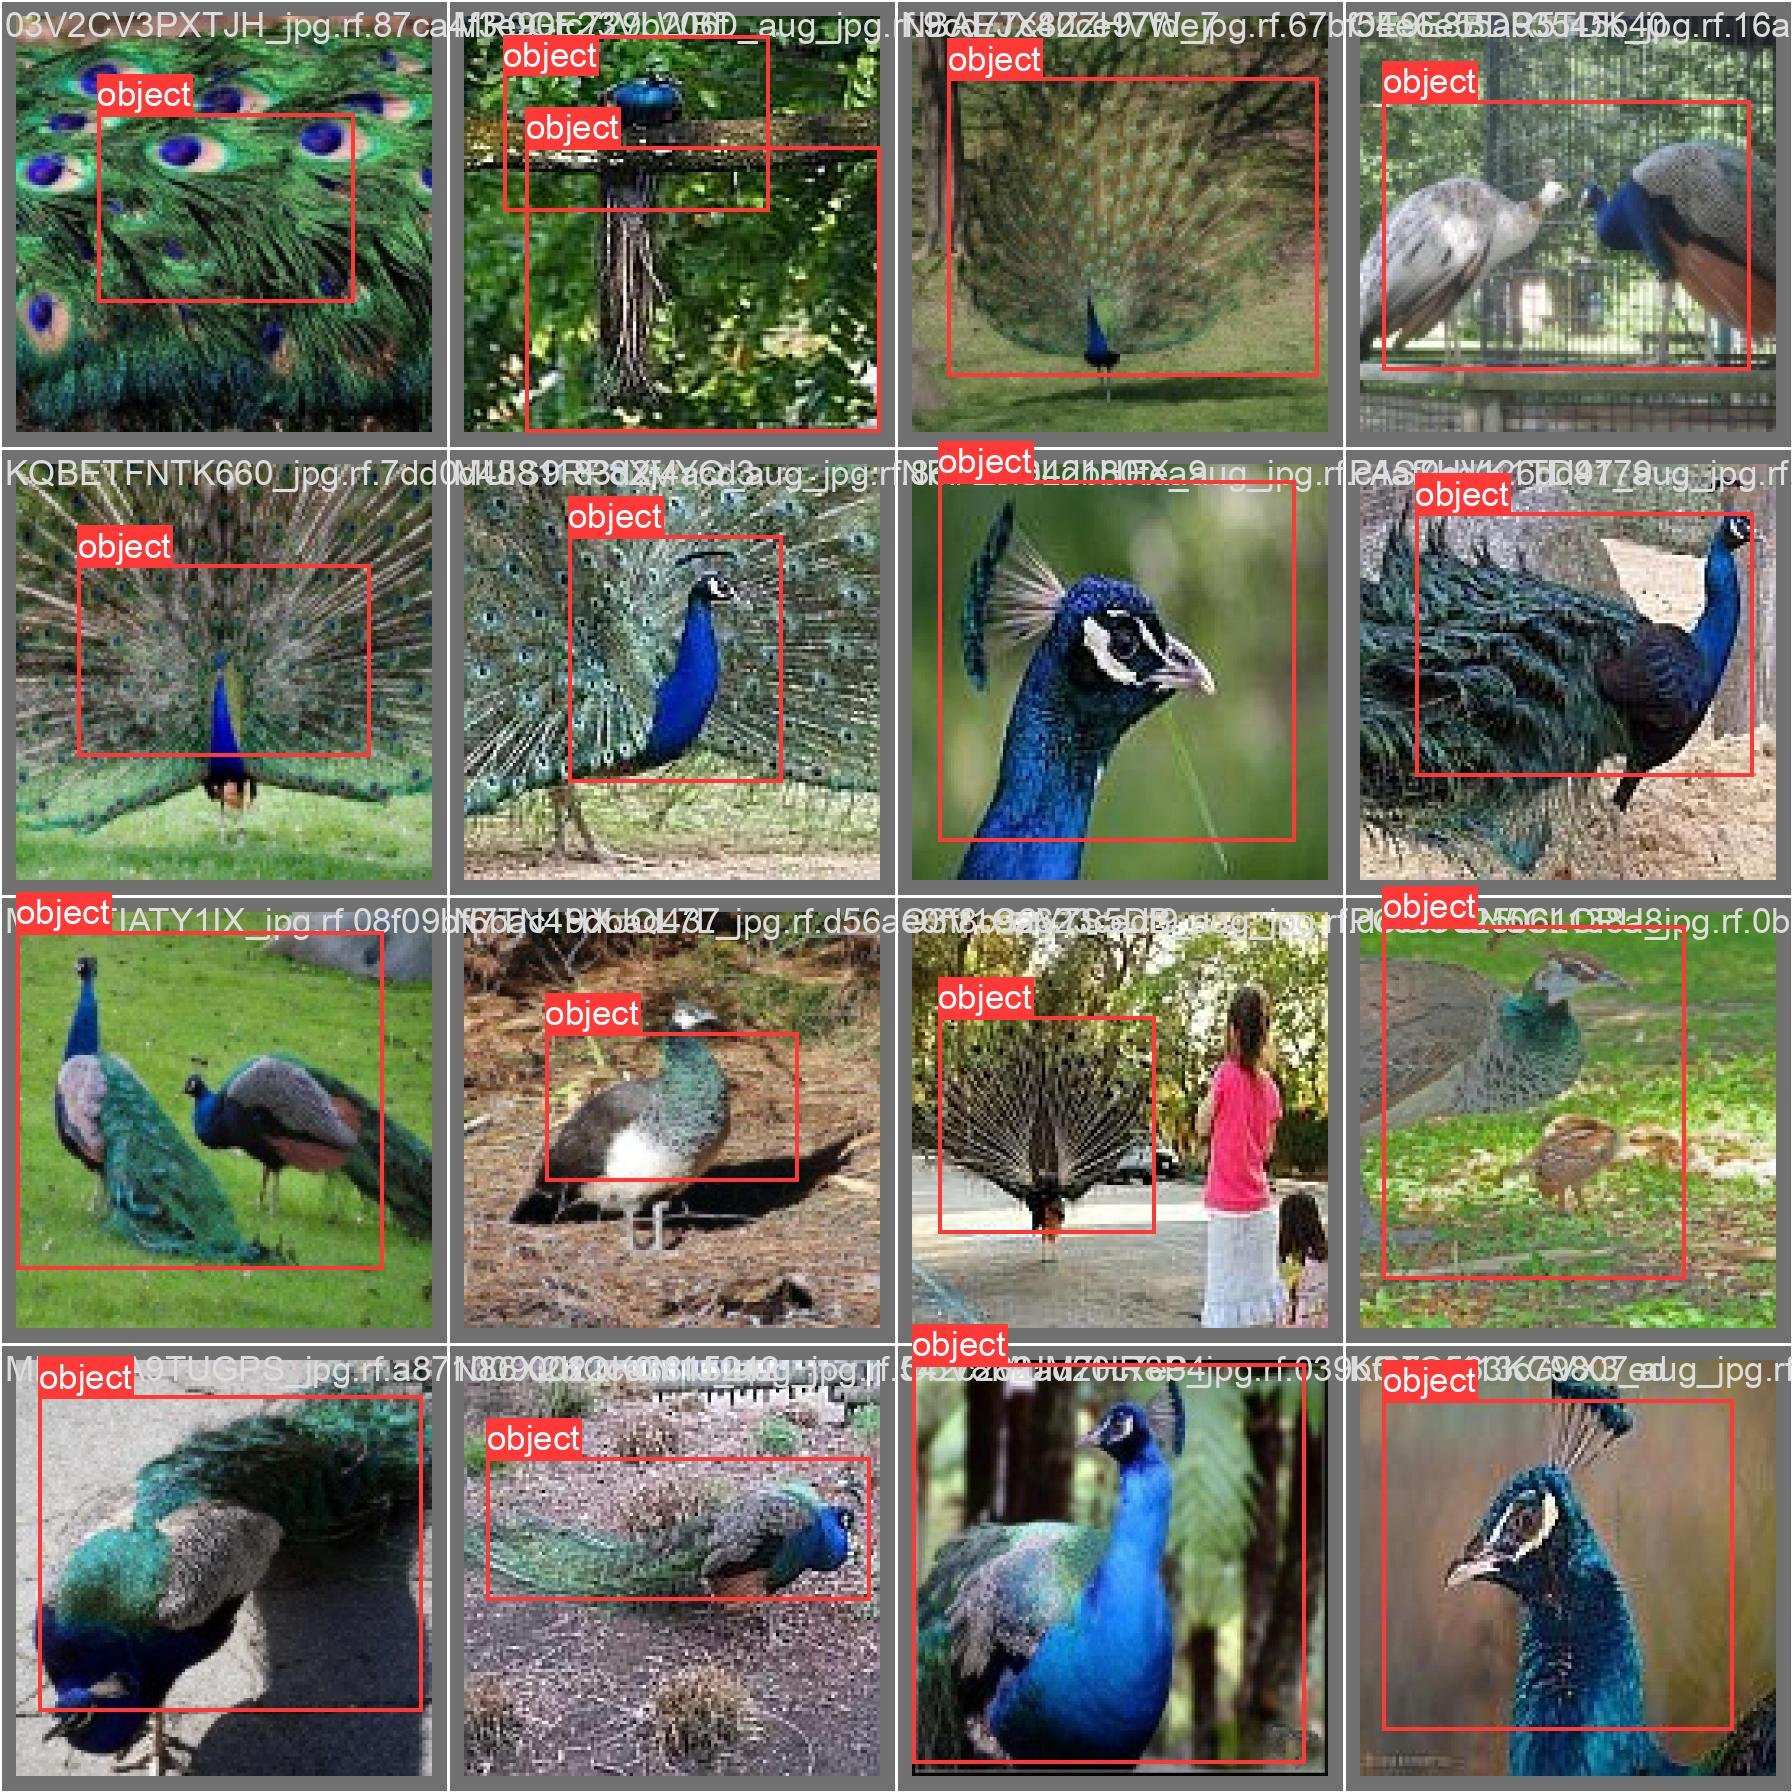

In [18]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


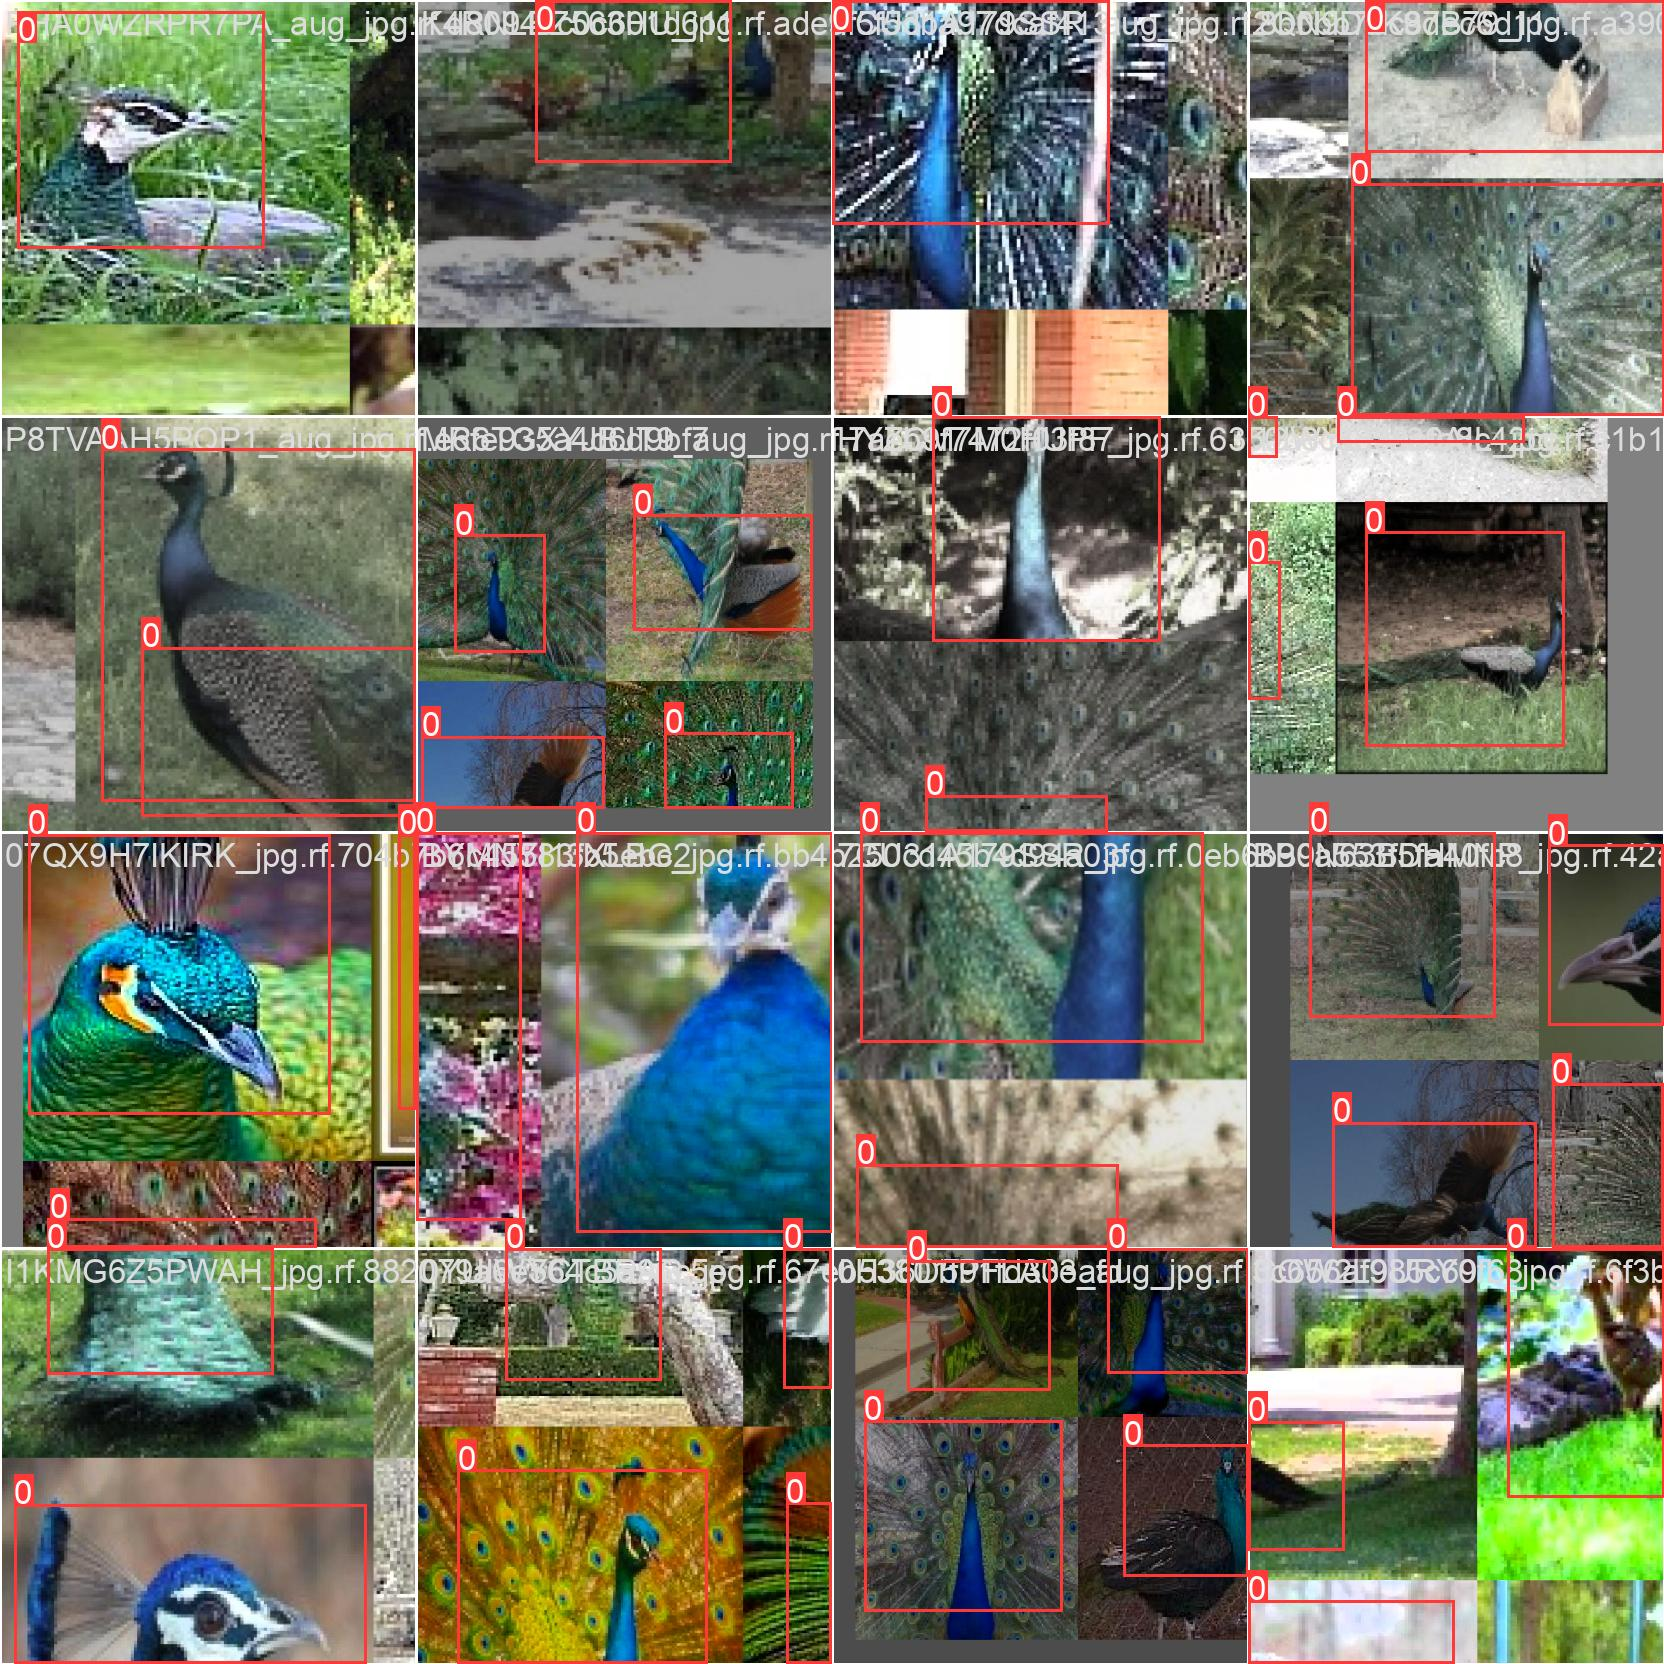

In [19]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

# Run Inference With Trained Weights

Next, we can run inference with a pretrained checkpoint on all images in the `test/images` folder to understand how our model performs on our test set.

In [20]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [21]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In the snippet below, replace `Cash-Counter-10` with the name of the folder in which your dataset is stored.

In [22]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/yolov5s.pt --img 416 --conf 0.4 --source /content/yolov5/peacock-1/test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/yolov5s.pt'], source=/content/yolov5/peacock-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-303-gcf8b67b7 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

100% 14.1M/14.1M [00:00<00:00, 40.7MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/32 /content/yolov5/peacock-1/test/images/0YUIWYCTBRAC_aug_jpg.rf.dafd740a64dbf8c8e0259786759ee47f.jpg: 416x416 (no detections), 7.4ms
image 2/32 /content/yolov5/peacock-1/test/images/1LPZ6KY594E8_aug_jpg.rf.0cef533e3d67538a2e3211

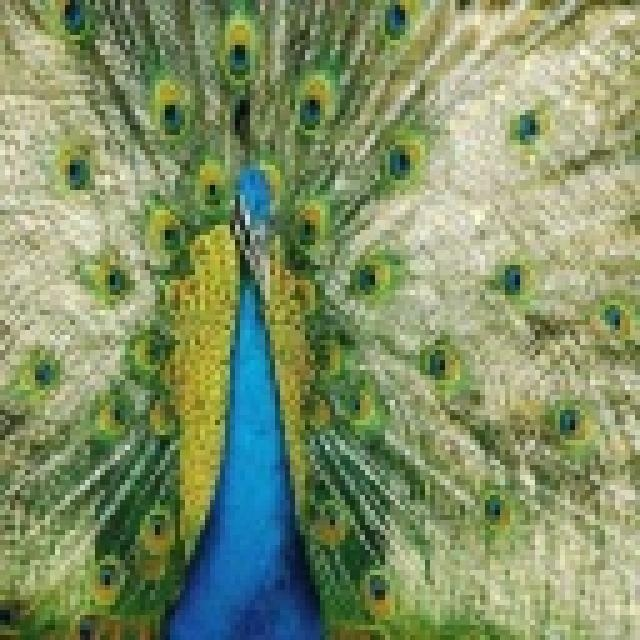

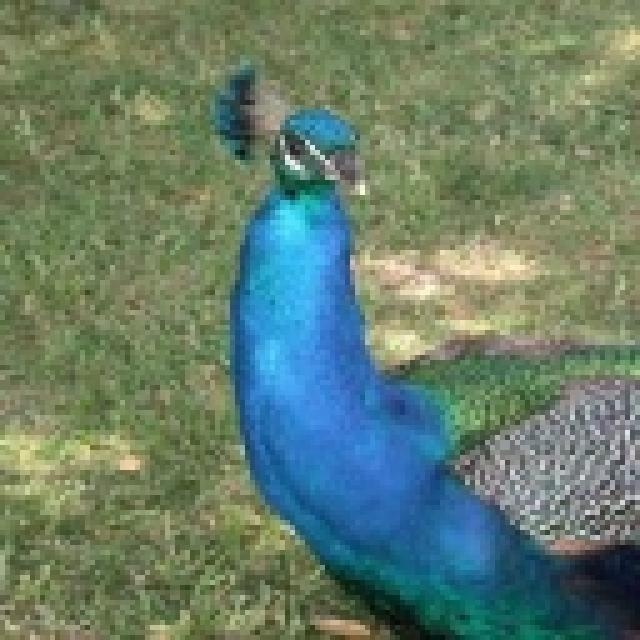

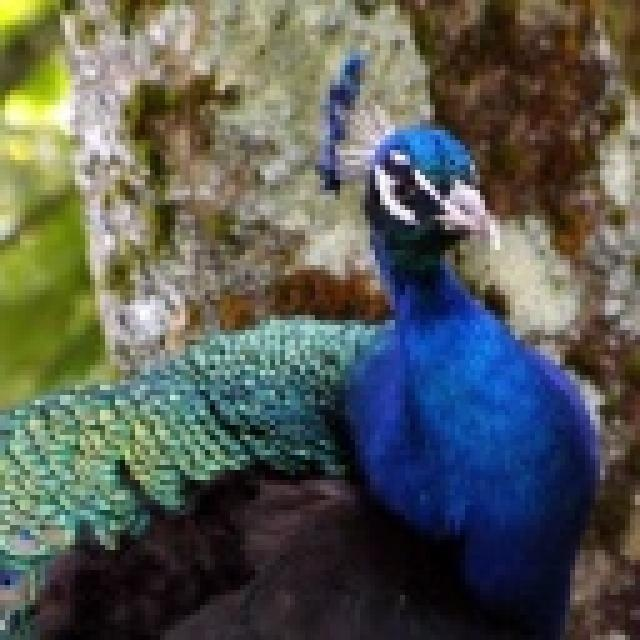

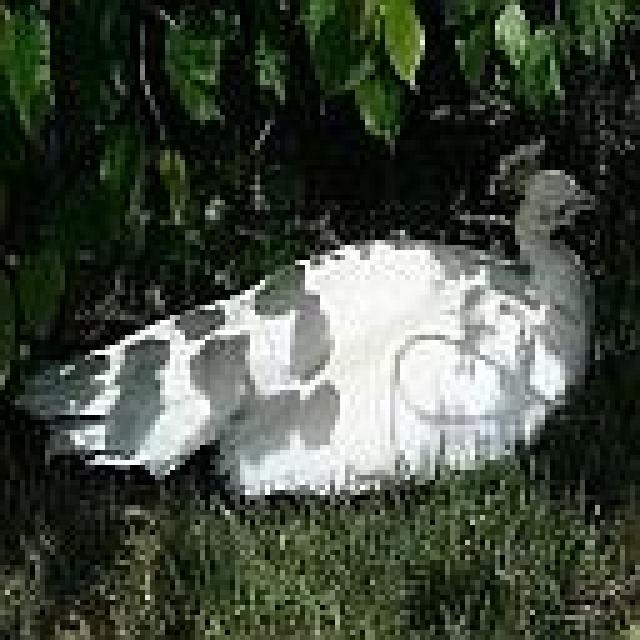

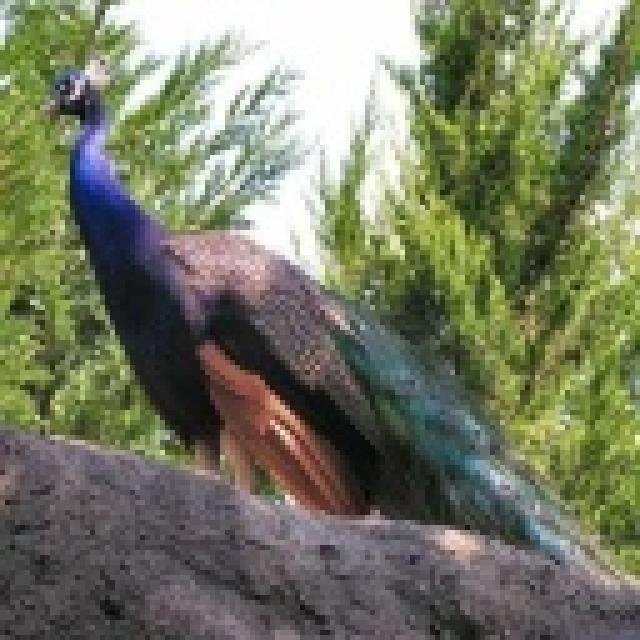

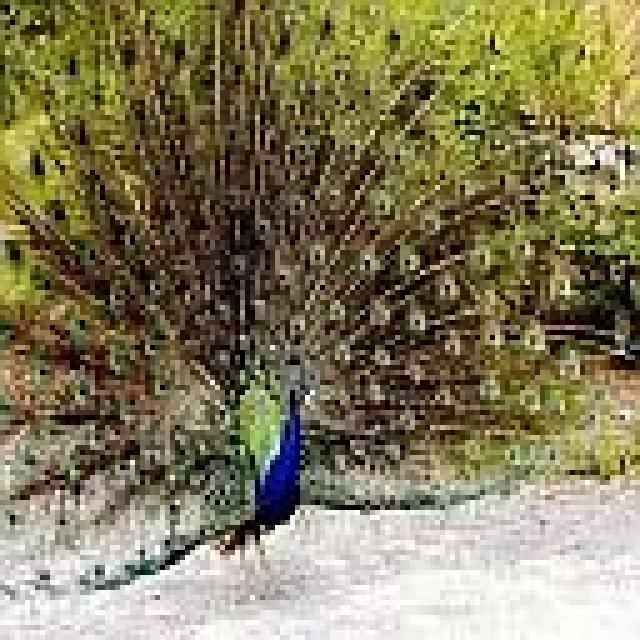

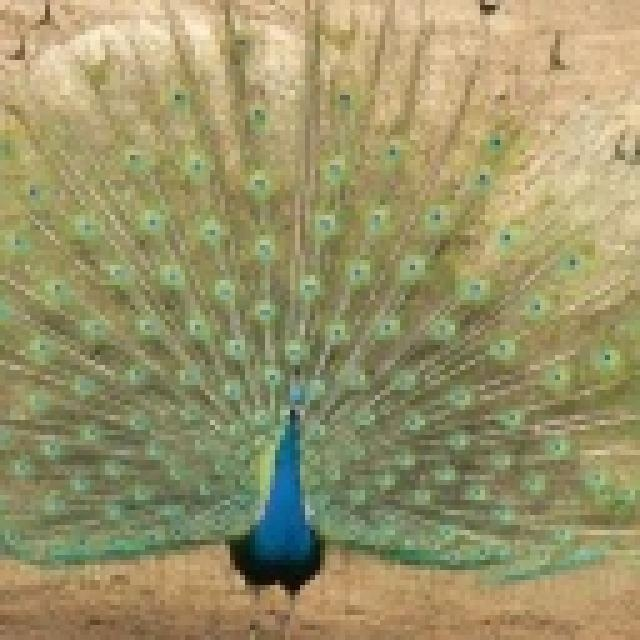

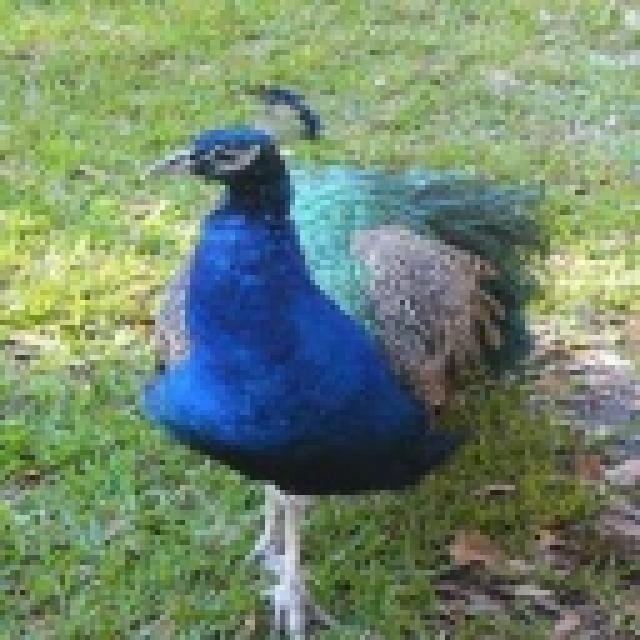

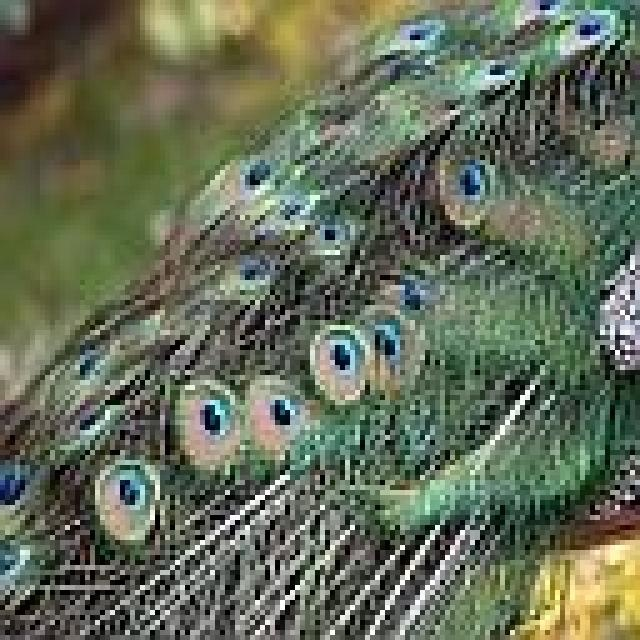

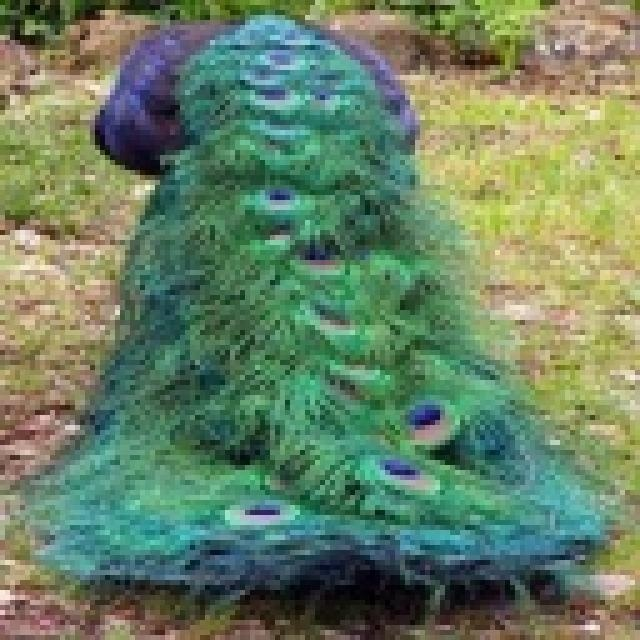

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))